In [32]:
import river
import pandas as pd

In [33]:
data_path = "../data/sys_freq_events.csv"
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (9647, 18)
Columns: ['pid', 'comm', 'uid', 'gid', 'ppid', 'user_pid', 'user_ppid', 'cgroup_id', 'cgroup_name', 'user', 'syscall_vector_json', 'distinct_syscalls', 'total_syscalls', 'wall_time_dt', 'wall_time_ms', 'container_id', 'container_image', 'container_labels_json']


In [34]:
import json

MAX_SYSCALLS = 500

def parse_syscall_vector(json_str):
    if pd.isna(json_str):
        return {str(i): 0 for i in range(MAX_SYSCALLS)}

    # Fix for embedded double quotes in CSV
    try:
        cleaned = json_str.replace('""', '"')
        raw = json.loads(cleaned)
    except Exception as e:
        print("JSON parse error:", e, "on:", json_str[:80])
        return {str(i): 0 for i in range(MAX_SYSCALLS)}

    vec = {str(i): 0 for i in range(MAX_SYSCALLS)}
    for k, v in raw.items():
        try:
            idx = int(k)
            if idx < MAX_SYSCALLS:
                vec[str(idx)] = int(v)  # string → int
        except Exception:
            continue
    return vec

df["syscall_vector"] = df["syscall_vector_json"].apply(parse_syscall_vector)

In [35]:
context_cols = [
    "pid", "comm", "user", "container_id", 
    "container_image", "wall_time_ms"
]
context = df[context_cols].copy()

In [36]:
    records = []
    for i, row in df.iterrows():
        features = row["syscall_vector"]
        ctx = context.iloc[i].to_dict()
        records.append((features, ctx))
    
    print("\nExample parsed record with context:")
    print(records[0])


Example parsed record with context:
({'0': 2, '1': 0, '2': 0, '3': 4, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 2, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 1, '42': 0, '43': 0, '44': 0, '45': 0, '46': 2, '47': 9, '48': 0, '49': 1, '50': 0, '51': 1, '52': 0, '53': 0, '54': 1, '55': 0, '56': 1, '57': 0, '58': 0, '59': 0, '60': 0, '61': 0, '62': 0, '63': 0, '64': 0, '65': 0, '66': 0, '67': 0, '68': 0, '69': 0, '70': 0, '71': 0, '72': 0, '73': 0, '74': 0, '75': 0, '76': 0, '77': 0, '78': 0, '79': 0, '80': 0, '81': 0, '82': 0, '83': 0, '84': 0, '85': 0, '86': 0, '87': 1, '88': 0, '89': 0, '90': 0, '91': 0, '92': 0, '93': 0, '94': 0, '95': 0, '96': 0, '97': 0, '98': 0, '99': 0, '100': 0, '101': 0, '102': 0, '103': 0, '104': 0, '105': 0, '106': 0, '

In [37]:
from river import compose, preprocessing, anomaly
import numpy as np

In [38]:
from collections import defaultdict
import math
def build_ocsvm_model():
    return compose.Pipeline(
        preprocessing.StandardScaler(),
        anomaly.QuantileFilter(
            anomaly.OneClassSVM(nu=0.2),
            q=0.95
        )
    )

first_nonzero = {}
seen_counts = defaultdict(int)
WARMUP_EVENTS = 35
models = defaultdict(build_ocsvm_model)
scores = []

for features, meta in records:
    container = meta.get("container_image")
    if not container or (isinstance(container, float) and pd.isna(container)):
        continue

    model = models[container]
    seen_counts[container] += 1
    idx = seen_counts[container]
    
    score = model.score_one(features)
    model.learn_one(features)
    if score == 0:
        continue

    if container not in first_nonzero:
        first_nonzero[container] = idx
        print(f"⚡ First non-zero anomaly score for {container} "
              f"at event #{idx} (score={score:.4f})")
    if idx > WARMUP_EVENTS:
        record_out = {**meta, **features, "anomaly_score": score}
        scores.append(record_out)

container_names = list(models.keys())
print(f"✅ Trained {len(models)} per-container models:")
for name in container_names:
    print(f"   - {name}")

⚡ First non-zero anomaly score for grafana/grafana:latest at event #7 (score=0.0689)
⚡ First non-zero anomaly score for clickhouse/clickhouse-server:latest at event #7 (score=-0.0665)
⚡ First non-zero anomaly score for apache/kafka:latest at event #7 (score=0.0092)
⚡ First non-zero anomaly score for provectuslabs/kafka-ui:latest at event #7 (score=0.0502)
✅ Trained 4 per-container models:
   - provectuslabs/kafka-ui:latest
   - apache/kafka:latest
   - grafana/grafana:latest
   - clickhouse/clickhouse-server:latest


In [39]:
for container, count in seen_counts.items():
    if count < WARMUP_EVENTS:
        print(f"⚠️ Container {container} has only {count} events (< {WARMUP_EVENTS}), skipping metrics")



📊 Metrics for container: apache/kafka:latest
Mean: 0.1245, Std: 0.1045
Min: -0.1475, Max: 0.4446
95th percentile: 0.2918 → anomaly rate ~ 5.08%
99th percentile: 0.4315 → anomaly rate ~ 1.69%


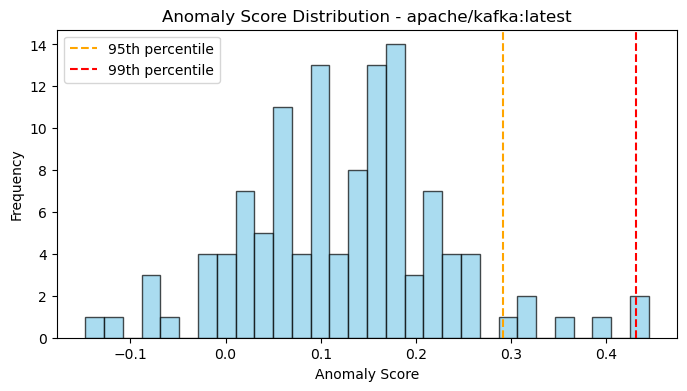


📊 Metrics for container: clickhouse/clickhouse-server:latest
Mean: 0.1562, Std: 0.2241
Min: -0.5098, Max: 0.7740
95th percentile: 0.5192 → anomaly rate ~ 5.08%
99th percentile: 0.6283 → anomaly rate ~ 1.69%


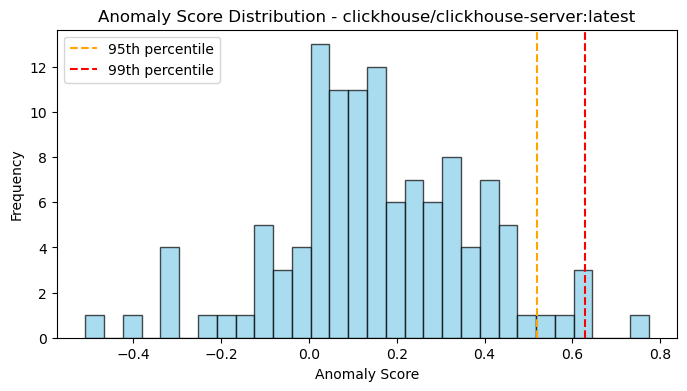


📊 Metrics for container: grafana/grafana:latest
Mean: -0.0097, Std: 0.6768
Min: -0.6382, Max: 9.7741
95th percentile: 0.1407 → anomaly rate ~ 5.22%
99th percentile: 0.6294 → anomaly rate ~ 1.12%


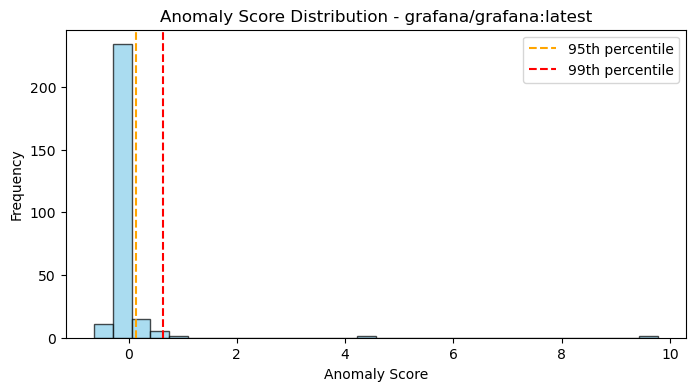


📊 Metrics for container: provectuslabs/kafka-ui:latest
Mean: -0.0131, Std: 0.0454
Min: -0.1292, Max: 0.1806
95th percentile: 0.0642 → anomaly rate ~ 5.08%
99th percentile: 0.0944 → anomaly rate ~ 1.69%


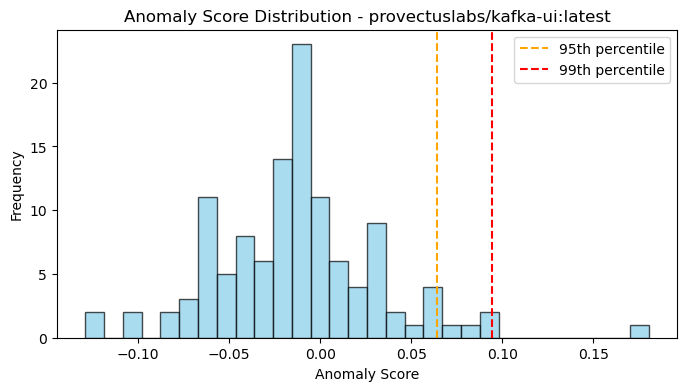

In [40]:
import matplotlib.pyplot as plt
if scores:
    results = pd.DataFrame(scores)
    for container, df_group in results.groupby("container_image"):
        if df_group.empty:
            continue
        
        mean_score = df_group["anomaly_score"].mean()
        std_score = df_group["anomaly_score"].std()
        min_score = df_group["anomaly_score"].min()
        max_score = df_group["anomaly_score"].max()
        q95 = np.percentile(df_group["anomaly_score"], 95)
        q99 = np.percentile(df_group["anomaly_score"], 99)
        rate_q95 = (df_group["anomaly_score"] > q95).mean()
        rate_q99 = (df_group["anomaly_score"] > q99).mean()
    
        print(f"\n📊 Metrics for container: {container}")
        print(f"Mean: {mean_score:.4f}, Std: {std_score:.4f}")
        print(f"Min: {min_score:.4f}, Max: {max_score:.4f}")
        print(f"95th percentile: {q95:.4f} → anomaly rate ~ {rate_q95*100:.2f}%")
        print(f"99th percentile: {q99:.4f} → anomaly rate ~ {rate_q99*100:.2f}%")

        # --- Plot histogram ---
        plt.figure(figsize=(8, 4))
        plt.hist(df_group["anomaly_score"], bins=30, alpha=0.7, color="skyblue", edgecolor="black")
        plt.axvline(q95, color="orange", linestyle="--", label="95th percentile")
        plt.axvline(q99, color="red", linestyle="--", label="99th percentile")
        plt.title(f"Anomaly Score Distribution - {container}")
        plt.xlabel("Anomaly Score")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
else:
    print("⚠️ No containers reached warm-up threshold, no metrics available yet.")